In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import models
from keras import layers
from keras.api.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from geneticalgorithm import geneticalgorithm as ga
from matplotlib import pyplot as plt

In [2]:
print("GPU dostępny:", tf.config.list_physical_devices('GPU'))

GPU dostępny: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Rough Set Flow Graph (RSFG)

In [3]:
def get_rsfg(sis):
    
    num_cols = sis.shape[1]

    rsfg_columns = ["level", "relation", "support", "certainty", "coverage", "strength"]

    rsfg_df = pd.DataFrame(columns=rsfg_columns)

    for level in range(num_cols - 1):
        
        edge_counts = {}
        source_counts = {}
        target_counts = {}
        total_possible = len(sis.iloc[:, level + 1])
        
        for _, row in sis.iterrows():
            
            source = str(row.iloc[level])
            target = str(row.iloc[level + 1])
            key = (source, target)
            edge_counts[key] = edge_counts.get(key, 0) + 1
            source_counts[source] = source_counts.get(source, 0) + 1
            target_counts[target] = target_counts.get(target, 0) + 1
            
        for (source, target), count in edge_counts.items():
            
            cer = count / source_counts[source] if source_counts[source] else 0
            cov = count / target_counts[target] if target_counts[target] else 0
            str_value = count / total_possible if total_possible else 0
            lev = f"{level}<>{level+1}"
            rel = f"{source}-->{target}"
            
            new_row = pd.DataFrame(data=np.array([[lev, rel, count, f"{cer:.6f}", f"{cov:.6f}", f"{str_value:.6f}"]]), columns=rsfg_columns)
            
            rsfg_df = pd.concat([rsfg_df, new_row], ignore_index=True)

    return rsfg_df

## Data (MNIST)

In [4]:
(x_train_valid, y_train_valid), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, stratify=y_train_valid)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

# Model (unreadable)

### Load model and dataframe, if you already have them locally:

In [ ]:
model = models.load_model('mnist_model.keras')

In [ ]:
artifact_clusters = pd.read_csv('artifact_clusters.csv')
print(artifact_clusters)

# Start training if no model loaded locally

In [5]:
artifact_clusters = pd.DataFrame()
print(artifact_clusters)

Empty DataFrame
Columns: []
Index: []


In [ ]:
# TODO: ekesperymenty z ilością filtrow

n_filters_conv_1 = 4 # liczba filtrów w pierwszej warstwie konwolucyjnej
filter_size_conv_1 = 5 # rozmiar okienka konwolucji
n_filters_conv_2 = 4 # liczba filtrów w drugiej warstwie konwolucyjnej
filter_size_conv_2 = 5 # rozmiar okienka konwolucji
n_neurons_dense_1 = 50 # liczba neuronów w pierwszej warstwie gęstej
n_neurons_dense_2 = 10 # liczba neuronów w drugiej warstwie gęstej

n_epochs = 20 # liczba epok
batch_size = 16 # rozmiar paczki

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(n_filters_conv_1, (filter_size_conv_1, filter_size_conv_1), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
model.add(layers.Conv2D(n_filters_conv_2, (filter_size_conv_2, filter_size_conv_2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(n_neurons_dense_1, activation='relu'))
model.add(layers.Dense(n_neurons_dense_2, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/ms/DEV/huretex/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-30 11:46:06.448129: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-04-30 11:46:06.448162: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-30 11:46:06.448173: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-30 11:46:06.448198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-30 11:46:06.448216: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fact

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 4)      │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        80,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,068 (316.67 KB)

 Trainable params: 81,068 (316.67 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(x_valid, y_valid), verbose=2)

Epoch 1/20


2025-04-30 11:46:15.464208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3000/3000 - 24s - 8ms/step - accuracy: 0.9378 - loss: 0.2249 - val_accuracy: 0.9643 - val_loss: 0.1369
Epoch 2/20
3000/3000 - 22s - 7ms/step - accuracy: 0.9589 - loss: 0.3260 - val_accuracy: 0.9545 - val_loss: 0.6101
Epoch 3/20
3000/3000 - 22s - 7ms/step - accuracy: 0.9521 - loss: 1.5185 - val_accuracy: 0.9470 - val_loss: 2.9147
Epoch 4/20
3000/3000 - 22s - 7ms/step - accuracy: 0.9389 - loss: 8.3254 - val_accuracy: 0.9028 - val_loss: 22.2632
Epoch 5/20
3000/3000 - 23s - 8ms/step - accuracy: 0.9218 - loss: 36.4263 - val_accuracy: 0.8755 - val_loss: 91.1292
Epoch 6/20
3000/3000 - 23s - 8ms/step - accuracy: 0.9022 - loss: 149.4753 - val_accuracy: 0.9072 - val_loss: 208.7523
Epoch 7/20
3000/3000 - 23s - 8ms/step - accuracy: 0.8855 - loss: 528.2419 - val_accuracy: 0.8831 - val_loss: 851.8414
Epoch 8/20
3000/3000 - 23s - 8ms/step - accuracy: 0.8750 - loss: 1501.7623 - val_accuracy: 0.8736 - val_loss: 2503.6118
Epoch 9/20
3000/3000 - 23s - 8ms/step - accuracy: 0.8653 - loss: 3587.1311 - val_a

In [10]:
# SAVE MODEL LOCALLY
model.save('mnist_model.keras')

In [10]:
layer_outputs = [layer.output for layer in model.layers]
print("Input: ", model.layers[0].input.shape)
print("Output: ", layer_outputs)
activation_model = models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

Input:  (None, 28, 28, 1)
Output:  [<KerasTensor shape=(None, 24, 24, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>, <KerasTensor shape=(None, 20, 20, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>, <KerasTensor shape=(None, 1600), dtype=float32, sparse=False, ragged=False, name=keras_tensor_6>, <KerasTensor shape=(None, 50), dtype=float32, sparse=False, ragged=False, name=keras_tensor_10>, <KerasTensor shape=(None, 10), dtype=float32, sparse=False, ragged=False, name=keras_tensor_15>]


In [11]:
activations = activation_model.predict(x=x_train)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [12]:
for f in range(n_filters_conv_1):

    print('filter: '+str(f))

    activations_f = activations[0][:,:,:,f]
    print(activations_f.shape)
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    print(activations_f.shape)
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)

    artifact_clusters['l0_f'+str(f)] = ac_f.labels_

filter: 0
(48000, 24, 24)
(48000, 576)
filter: 1
(48000, 24, 24)
(48000, 576)
filter: 2
(48000, 24, 24)
(48000, 576)
filter: 3
(48000, 24, 24)
(48000, 576)


In [ ]:
for f in range(n_filters_conv_2):

    print('filter: '+str(f))

    activations_f = activations[1][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)

    artifact_clusters['l1_f'+str(f)] = ac_f.labels_

filter: 0
filter: 1
filter: 2
filter: 3


In [17]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3
0          4      3      7      6      5      6      6      6
1          3      4      8      5      3      5      4      1
2          2      1      6      9      2      1      1      0
3          3      4      9      5      3      9      8      5
4          0      0      2      1      0      0      0      9
...      ...    ...    ...    ...    ...    ...    ...    ...
47995      5      4      6      3      3      5      2      1
47996      5      5      4      3      1      3      2      5
47997      2      9      5      8      2      1      1      0
47998      5      4      9      3      1      9      2      5
47999      1      6      1      7      7      2      7      2

[48000 rows x 8 columns]


In [18]:
activations_d_1 = activations[3]
ac_d = AgglomerativeClustering(n_clusters=10).fit(activations_d_1)
artifact_clusters['l3'] = ac_d.labels_

In [ ]:
# TODO: czy brac oryginalne predykcje czy wyniki modelu?

predictions = model.predict(x=x_train)
pred = np.argmax(predictions, axis=1)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [1]:
predictions.shape

NameError: name 'predictions' is not defined

In [133]:
a = [p for p in pred if p == 8]

print(a)
print(len(a))


[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

In [46]:
artifact_clusters['p'] = pred

In [47]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3  l3  p
0          4      3      7      6      5      6      6      6   6  7
1          3      4      8      5      3      5      4      1   3  5
2          2      1      6      9      2      1      1      0   4  4
3          3      4      9      5      3      9      8      5   1  8
4          0      0      2      1      0      0      0      9   4  0
...      ...    ...    ...    ...    ...    ...    ...    ...  .. ..
47995      5      4      6      3      3      5      2      1   1  8
47996      5      5      4      3      1      3      2      5   6  3
47997      2      9      5      8      2      1      1      0   0  9
47998      5      4      9      3      1      9      2      5   4  6
47999      1      6      1      7      7      2      7      2   1  6

[48000 rows x 10 columns]


In [48]:
# SAVE ARIFACT CLUSTERS to
artifact_clusters.to_csv('artifact_clusters.csv', index=False)

### Generate artifact_clusters for just one class

In [178]:
e_artifact_clusters = artifact_clusters[artifact_clusters['p'] == 2]

In [179]:
print(e_artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3  l3  p
5          2      2      1      2      8      8      3      2   5  2
18         1      2      9      5      7      2      7      1   4  2
21         6      2      3      2      1      5      3      5   6  2
26         6      2      3      2      1      5      3      5   9  2
44         4      3      8      6      6      5      4      8   6  2
...      ...    ...    ...    ...    ...    ...    ...    ...  .. ..
47943      6      2      3      2      8      8      3      5   5  2
47945      6      2      3      2      8      8      3      5   5  2
47962      6      2      8      5      9      5      4      1   6  2
47970      6      2      3      6      1      5      3      5   9  2
47973      6      2      3      2      8      8      3      5   9  2

[3816 rows x 10 columns]


## Twin (readable)

In [180]:
sis = pd.DataFrame()

In [181]:
sis['conv1'] = e_artifact_clusters.astype(str).loc[:,['l0_f0', 'l0_f1', 'l0_f2', 'l0_f3']].apply('_'.join, axis=1)

In [182]:
sis['conv2'] = e_artifact_clusters.astype(str).loc[:,['l1_f0', 'l1_f1', 'l1_f2', 'l1_f3']].apply('_'.join, axis=1)

In [183]:
sis['dense1'] = e_artifact_clusters['l3']

In [184]:
sis['output'] = e_artifact_clusters['p']

In [185]:
print(sis)

         conv1    conv2  dense1  output
5      2_2_1_2  8_8_3_2       5       2
18     1_2_9_5  7_2_7_1       4       2
21     6_2_3_2  1_5_3_5       6       2
26     6_2_3_2  1_5_3_5       9       2
44     4_3_8_6  6_5_4_8       6       2
...        ...      ...     ...     ...
47943  6_2_3_2  8_8_3_5       5       2
47945  6_2_3_2  8_8_3_5       5       2
47962  6_2_8_5  9_5_4_1       6       2
47970  6_2_3_6  1_5_3_5       9       2
47973  6_2_3_2  8_8_3_5       9       2

[3816 rows x 4 columns]


In [186]:
rsfg = get_rsfg(sis)

In [187]:
print(rsfg)

    level           relation support certainty  coverage  strength
0    0<>1  2_2_1_2-->8_8_3_2       5  0.454545  0.033113  0.001310
1    0<>1  1_2_9_5-->7_2_7_1       1  0.500000  1.000000  0.000262
2    0<>1  6_2_3_2-->1_5_3_5     530  0.192099  0.841270  0.138889
3    0<>1  4_3_8_6-->6_5_4_8      15  0.340909  0.333333  0.003931
4    0<>1  1_4_8_4-->6_2_4_1       2  0.666667  0.500000  0.000524
..    ...                ...     ...       ...       ...       ...
812  2<>3              3-->2     124  1.000000  0.032495  0.032495
813  2<>3              0-->2      78  1.000000  0.020440  0.020440
814  2<>3              7-->2      11  1.000000  0.002883  0.002883
815  2<>3              1-->2      90  1.000000  0.023585  0.023585
816  2<>3              8-->2      12  1.000000  0.003145  0.003145

[817 rows x 6 columns]


In [188]:
rsfg['confidence'] = 2*rsfg['certainty'].astype(float)*rsfg['coverage'].astype(float)/(rsfg['certainty'].astype(float)+rsfg['coverage'].astype(float))

In [189]:
print(rsfg)

    level           relation support certainty  coverage  strength  confidence
0    0<>1  2_2_1_2-->8_8_3_2       5  0.454545  0.033113  0.001310    0.061729
1    0<>1  1_2_9_5-->7_2_7_1       1  0.500000  1.000000  0.000262    0.666667
2    0<>1  6_2_3_2-->1_5_3_5     530  0.192099  0.841270  0.138889    0.312777
3    0<>1  4_3_8_6-->6_5_4_8      15  0.340909  0.333333  0.003931    0.337078
4    0<>1  1_4_8_4-->6_2_4_1       2  0.666667  0.500000  0.000524    0.571429
..    ...                ...     ...       ...       ...       ...         ...
812  2<>3              3-->2     124  1.000000  0.032495  0.032495    0.062945
813  2<>3              0-->2      78  1.000000  0.020440  0.020440    0.040061
814  2<>3              7-->2      11  1.000000  0.002883  0.002883    0.005749
815  2<>3              1-->2      90  1.000000  0.023585  0.023585    0.046083
816  2<>3              8-->2      12  1.000000  0.003145  0.003145    0.006270

[817 rows x 7 columns]


In [190]:
levels = rsfg['level'].unique()
print(levels)

['0<>1' '1<>2' '2<>3']


In [191]:
rsfg_layers = list()
node_dicts = list()

for level in levels:

    layer = rsfg.loc[rsfg['level']==level,:]
    layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)

    if len(node_dicts)==0:
        
        node_dict_1 = {key: i for i, key in enumerate(layer['source'].unique())}
        node_dicts.append(node_dict_1)

        layer['source_id'] = layer['source'].map(node_dict_1)

    else:

        layer['source_id'] = layer['source'].map(node_dicts[-1])        

    node_dict_2 = {key: i for i, key in enumerate(layer['target'].unique())}
    node_dicts.append(node_dict_2)

    layer['target_id'] = layer['target'].map(node_dict_2)
    
    layer = layer[['source_id', 'target_id', 'source', 'target', 'confidence']]
        
    rsfg_layers.append(layer)

/var/folders/0m/y35n_skn6dn_7xxvwx4kq9140000gn/T/ipykernel_17222/1748982612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)
/var/folders/0m/y35n_skn6dn_7xxvwx4kq9140000gn/T/ipykernel_17222/1748982612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)
/var/folders/0m/y35n_skn6dn_7xxvwx4kq9140000gn/T/ipykernel_17222/1748982612.py:14: SettingWithCopyWa

## Genetic Algorithm

https://pypi.org/project/geneticalgorithm/

In [192]:
def fitness(x):

    confidences = list()

    for i in range(len(x)-1):

        layer = rsfg_layers[i]

        confidence = layer.loc[(layer['source_id']==x[i]) & (layer['target_id']==x[i+1]), ['confidence']]

        if len(confidence)==0:

            return 0
            
        confidences.append(confidence['confidence'])

    return -np.min(np.array(confidences))  

[[0, 139], [0, 195], [0, 8], [0, 0]]
 The best solution found:                                                                           
 [ 6. 30.  4.  0.]

 Objective function:
 -0.06294461474389708


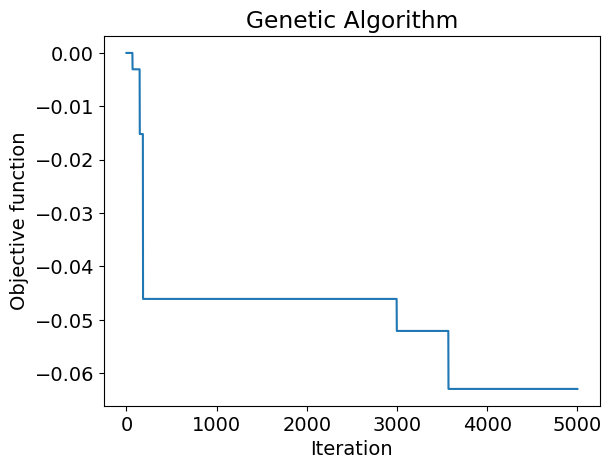

In [193]:
parameters = {'max_num_iteration': 5000,
              'population_size': 20,
              'parents_portion': 0.3,
              'mutation_probability':0.1,
              'crossover_probability': 0.1,
              'elit_ratio': 0.01,
              'crossover_type':'uniform',
              'max_iteration_without_improv': None}


varbounds = []

for d in node_dicts:

    varbounds.append([0,len(d)-1])

print(varbounds)

gen_alg = ga(function=fitness, dimension=len(varbounds), variable_type='int', variable_boundaries=np.array(varbounds), algorithm_parameters=parameters)

gen_alg.run()

In [194]:
best_path = gen_alg.output_dict['variable']

In [195]:
best_path_info = pd.DataFrame(columns=['confidence', 'source', 'target'])

for i in range(len(best_path)-1):

        layer = rsfg_layers[i]

        path_info = layer.loc[(layer['source_id']==best_path[i]) & (layer['target_id']==best_path[i+1]), ['confidence', 'source', 'target']]
    
        best_path_info = pd.concat([best_path_info.dropna(axis=1, how='all') , path_info], ignore_index=True)

print(best_path_info)

   confidence   source   target
0    0.219512  2_2_3_2  9_8_4_2
1    0.142077  9_8_4_2        3
2    0.062945        3        2


## Visualization

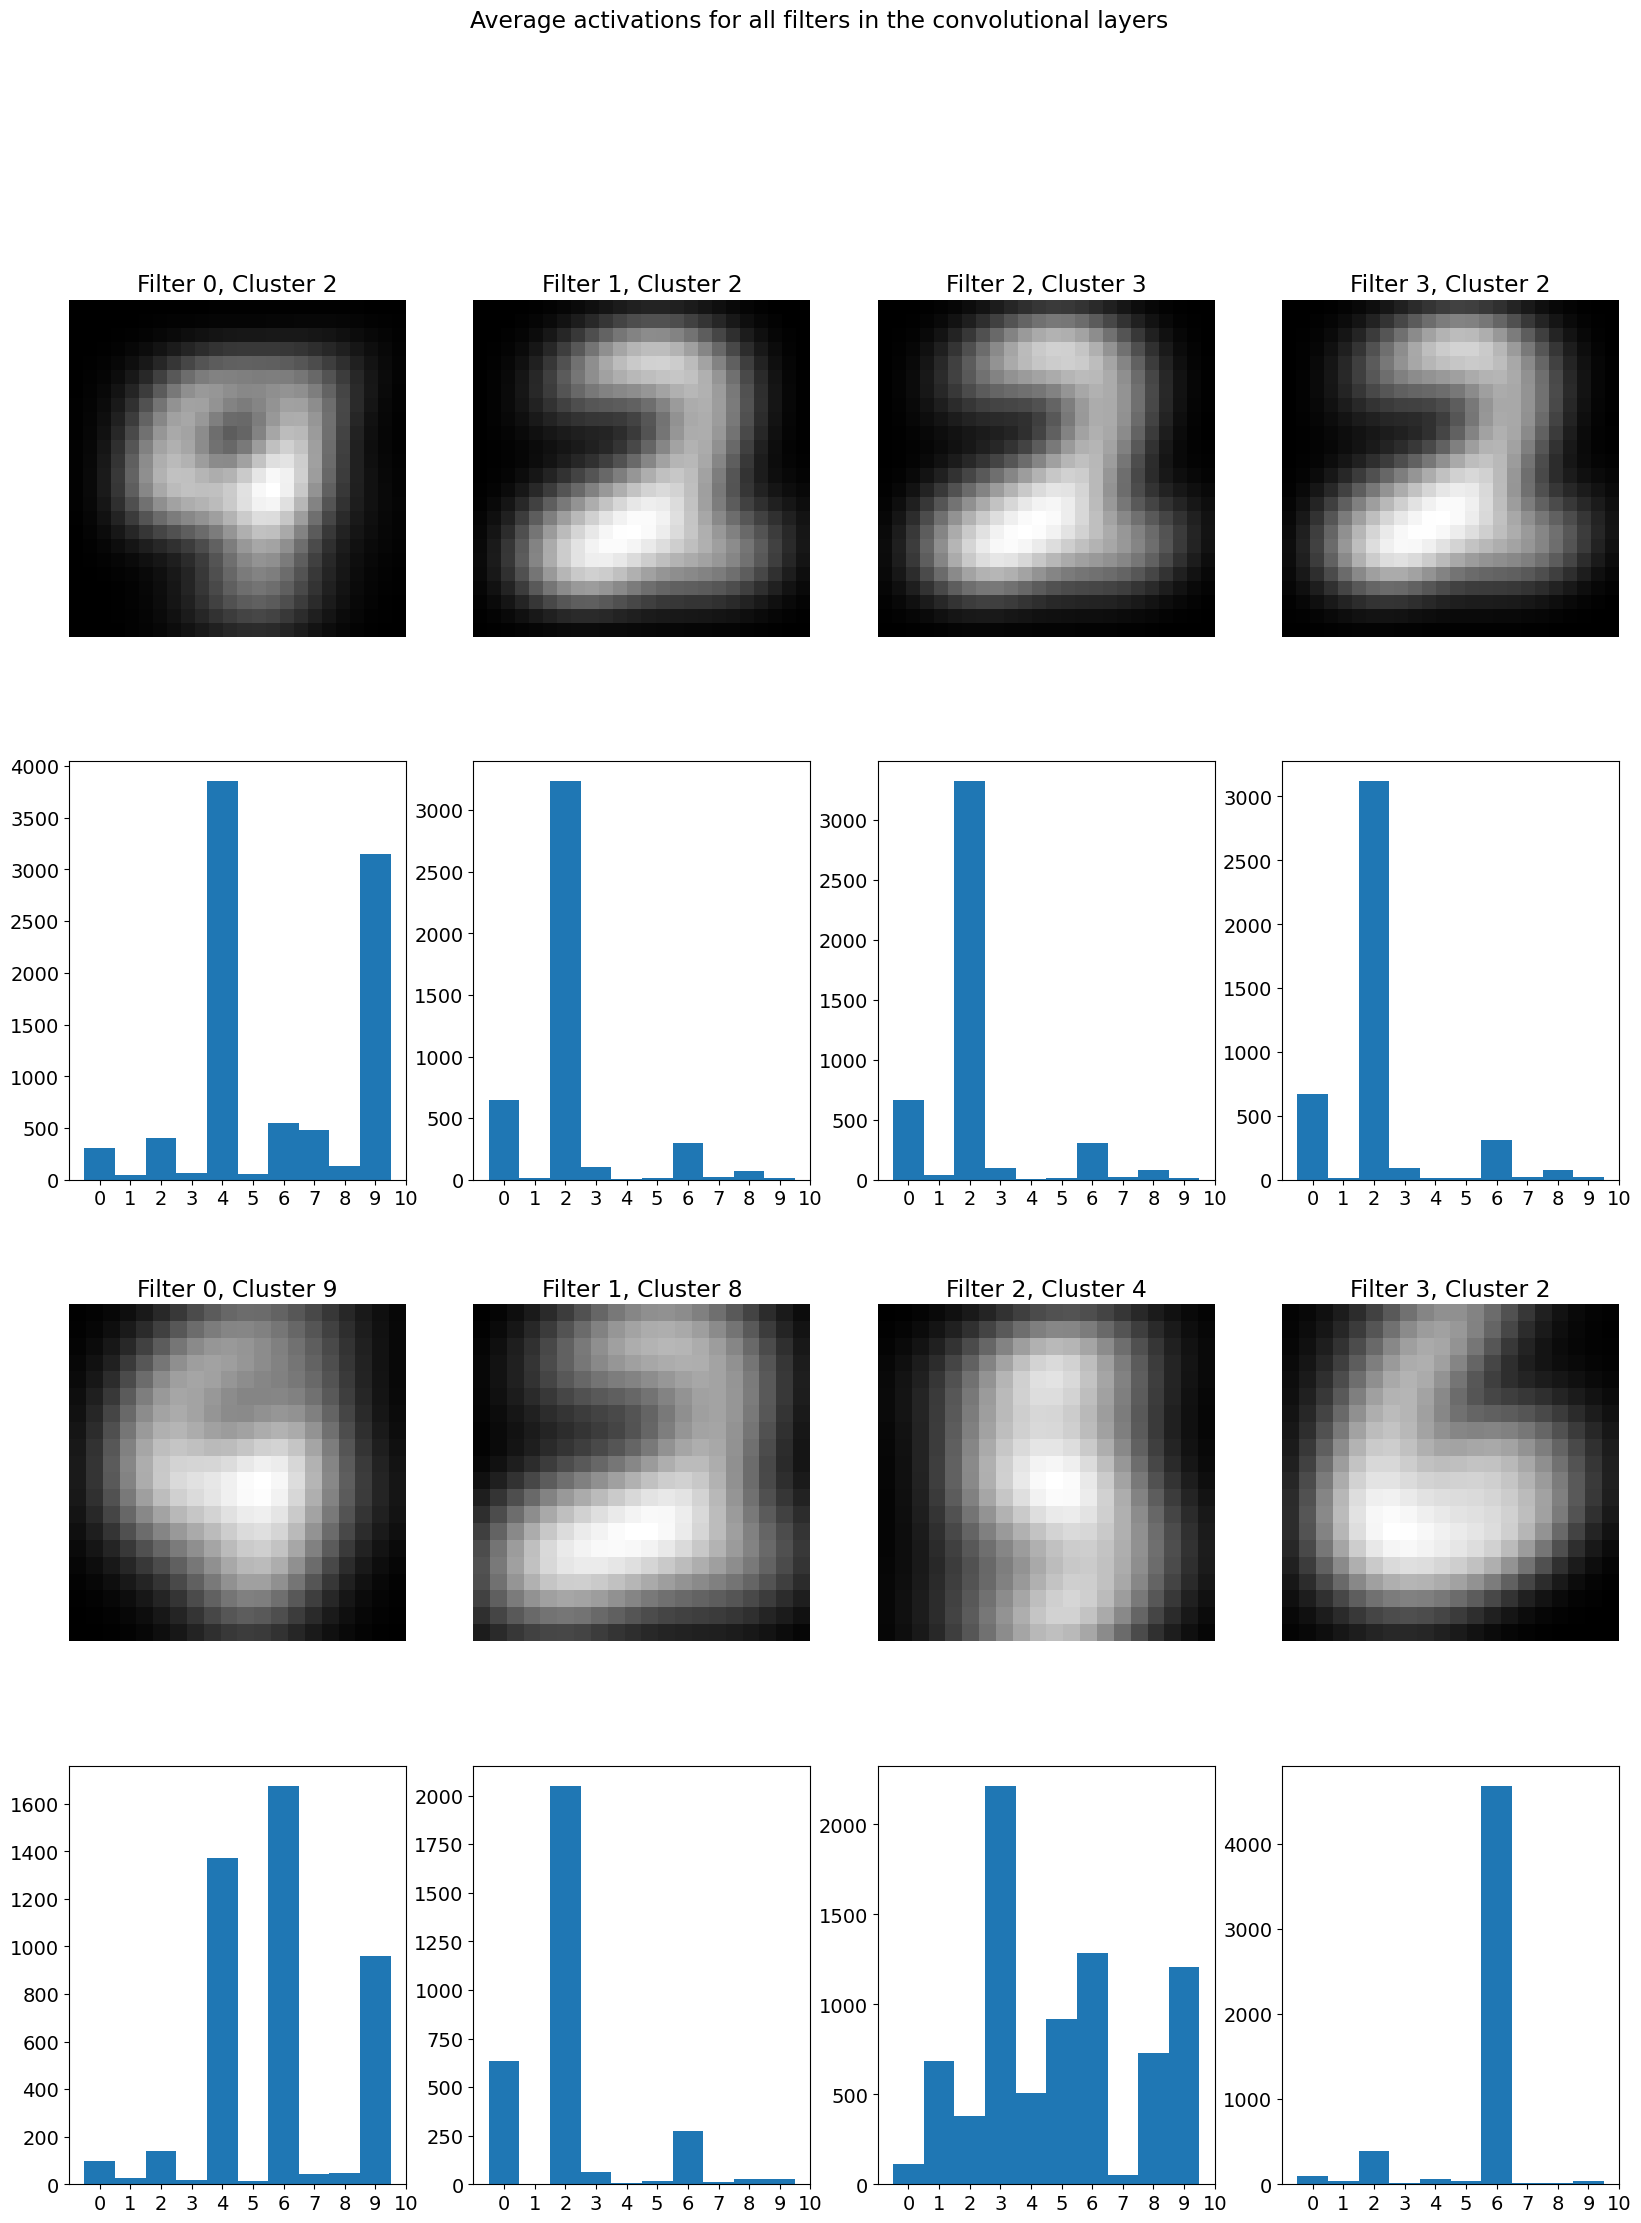

In [199]:
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(4, 4, figsize=(20, 25)) 
fig.suptitle("Average activations for all filters in the convolutional layers")

source_cluster_indexes = best_path_info.loc[:,'source'].str.split('_')
target_cluster_indexes = best_path_info.loc[:,'target'].str.split('_')

row = 0

for filter_index in range(4):

    source_cluster_index = int(source_cluster_indexes[0][filter_index])
    target_cluster_index = int(target_cluster_indexes[0][filter_index])
    
    activation_data_0 = activations[0][artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :, :, filter_index]
    cluster_0 = artifact_clusters.loc[artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :]

    activation_data_1 = activations[1][artifact_clusters[f'l1_f{filter_index}'] == target_cluster_index, :, :, filter_index]
    cluster_1= artifact_clusters.loc[artifact_clusters[f'l1_f{filter_index}'] == target_cluster_index, :]

    average_activation_0 = np.mean(activation_data_0, axis=0)
    average_activation_1 = np.mean(activation_data_1, axis=0)

    col = filter_index
            
    axes[2*row, col].imshow(average_activation_0, cmap=plt.get_cmap('gray'))
    axes[2*row, col].axis("off")
    axes[2*row, col].set_title(f"Filter {filter_index}, Cluster {source_cluster_index}")

    bins = np.arange(0, 9 + 1.5) - 0.5
    axes[2*row+1, col].hist(cluster_0['p'], bins)
    axes[2*row+1, col].set_xticks(bins + 0.5)

    axes[2*row+2, col].imshow(average_activation_1, cmap=plt.get_cmap('gray'))
    axes[2*row+2, col].axis("off")
    axes[2*row+2, col].set_title(f"Filter {filter_index}, Cluster {target_cluster_index}")

    bins = np.arange(0, 9 + 1.5) - 0.5
    axes[2*row+3, col].hist(cluster_1['p'], bins)
    axes[2*row+3, col].set_xticks(bins + 0.5)

plt.show()

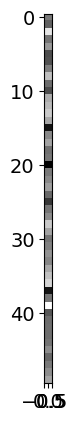

In [197]:
activation_data_3 = activations[3][artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :]
activation_data_3 = np.mean(activation_data_3, axis=0)
plt.imshow(activation_data_3.reshape(activation_data_3.shape[0], 1, 1), cmap=plt.get_cmap('gray'))